In [1]:
import random
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.models import Sequential
import numpy as np
import pickle
import json
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [2]:
lemmatizer = WordNetLemmatizer()
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaseb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaseb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
words = []
classes = []
documents = []
ignore_words = ["?", "!"]
data_file = open("data.json").read()
intents = json.loads(data_file)

In [6]:
data_file

'{"intents": [\n{"tag": "Greeting","patterns": ["hello there","how are you doing","how are you","hey","hi there","hi","hello","hi good morning","hi good afternoon","hi good evening"]},\n{"tag": "GreetingResponseYes","patterns": ["Yes I am ready to take the assessment","Yes I am ready", "I am good, I am ready to take the assessment","I am ready","I can take the test today","ready","all set","we can proceed","good to go","I am ready to take the test","I am ready to take the assessment","all set to take the assessment","all set to take the test","all good to take the assessment","I am ready for the assessment","Yes i am ready","Yes I am ready to take the assessment","I am ok and ready to take the assessment","okie dokie"]},\n{"tag": "GreetingResponseNo","patterns": [ "No I am not ready","I am not","Could you please reschedule the assessment","I am not  feeling well","I cannot attend it today","Can you reschedule the test?","Not today","Not sure","Sorry I cannot attend the assessment","I c

In [4]:
for intent in intents["intents"]:
    for pattern in intent["patterns"]:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent["tag"]))

        # adding classes to our class list
        if intent["tag"] not in classes:
            classes.append(intent["tag"])

In [5]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

pickle.dump(words, open("words.pkl", "wb"))
pickle.dump(classes, open("classes.pkl", "wb"))

In [6]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]

    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

<ipython-input-6-3cc44a25c62c>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [7]:
train_x = list(training[:, 0])
train_y = list(training[:, 1])
print("Training data created")

Training data created


In [8]:
# actual training
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation="softmax"))
model.summary()

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

# fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs = 50, validation_split=0.2,batch_size = 5, verbose = 2)
model.save("chatbot_model.h5", hist)
print("model created")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11136     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 19,717
Trainable params: 19,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
13/13 - 1s - loss: 1.6681 - accuracy: 0.2

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11136     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 19,717
Trainable params: 19,717
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
np.max(hist.history['accuracy'])

0.8095238208770752

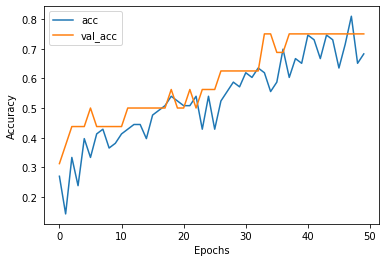

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

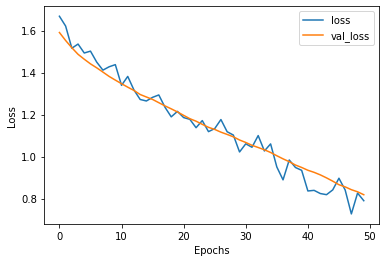

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [13]:
def clean_up_sentence(sentence):
    print(sentence)
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print("found in bag: %s" % w)
    return np.array(bag)

In [14]:
def predict_intent(text):
    p = bow(text, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.40
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
            return_list.append({"intent": classes[r[0]], "probability": str(r[1])})

    print(return_list)
    #return return_list
    #print(classes[r[0]])

In [75]:
test_sentence1 = "Hi how are you?"
predict_intent(test_sentence1)

test_sentence2 = "Yes i am ready!"
predict_intent(test_sentence2)

test_sentence3 = "Where am I"
predict_intent(test_sentence3)

Hi how are you?
1/1 [==============================] - 0s 18ms/step
[]
Yes i am ready!
1/1 [==============================] - 0s 20ms/step
[{'intent': 'GreetingResponseYes', 'probability': '0.5902458'}]
Where am I
1/1 [==============================] - 0s 17ms/step
[]
